# COGS 108 - EDA Checkpoint

# Names

- Anna Wang
- Chloe Salem
- Kristy Liou
- Maxtierney Arias
- Zeven Vidmar Barker

<a id='research_question'></a>
# Research Question

Can we predict which state in the USA will be covid-free first based on current hospital records, state regulations, and population?

# Setup

In [1]:
## YOUR CODE HERE
#importing needed libraries
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio


# reading data sets
population = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/national/totals/nst-est2020.csv")
vaccinations = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')
case_tracking = pd.read_csv('https://covidtracking.com/data/download/all-states-history.csv')
state_code = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')

# Data Cleaning

Describe your data cleaning steps here.

In [2]:
# Removed unnecessary columns in Population dataframe
population = population[5::]
population = population[['NAME', 'POPESTIMATE2020']]
population.rename(columns={"NAME": "state", "POPESTIMATE2020": "2020 population"}, errors="raise", inplace=True)
#population.set_index(['NAME'], inplace=True)
#population.set_index(['NAME'], inplace=True)

population.head()

,state,2020 population
5,Alabama,4921532
6,Alaska,731158
7,Arizona,7421401
8,Arkansas,3030522
9,California,39368078


In [3]:
# Removed unnecessary columns in vaccinations and renamed for easier readability 
vaccinations = vaccinations.drop(['daily_vaccinations_per_million', 'share_doses_used', 'daily_vaccinations_per_million', 'share_doses_used'], 1)
new_names = []
for col in vaccinations.columns:
    new_names.append(col.replace('_', ' '))
vaccinations.rename(columns=dict(zip(vaccinations.columns, new_names)), inplace=True)

In [4]:
# Dropping more unrelated columns to research question - including deaths, antibody tests, negative results, and positive results related to type of test
case_tracking = case_tracking[['date', 'state', 'hospitalized', 'hospitalizedCumulative', 'hospitalizedCurrently', 'hospitalizedIncrease', 'positive', 'recovered', 'totalTestEncountersViralIncrease', 'totalTestResults', 'totalTestResultsIncrease']]
new_names = []
for name in case_tracking.columns:
    new_names.append((re.sub(r"(\w)([A-Z])", r"\1 \2", name)).lower())
case_tracking.rename(columns=dict(zip(case_tracking.columns, new_names)), inplace=True)

In [5]:
case_tracking.head()

,date,state,hospitalized,hospitalized cumulative,hospitalized currently,hospitalized increase,positive,recovered,total test encounters viral increase,total test results,total test results increase
0,2021-02-23,AK,1260.0,1260.0,38.0,9,55560.0,NaN,0,1653425.0,4640
1,2021-02-23,AL,45250.0,45250.0,762.0,122,488973.0,275245.0,0,2265086.0,4825
2,2021-02-23,AR,14617.0,14617.0,545.0,47,316593.0,306382.0,0,2609837.0,4779
3,2021-02-23,AS,NaN,NaN,NaN,0,0.0,NaN,0,2140.0,0
4,2021-02-23,AZ,57072.0,57072.0,1515.0,78,810658.0,NaN,0,7478323.0,19439


In [6]:
vaccinations.head()

,date,location,total vaccinations,total distributed,people vaccinated,people fully vaccinated per hundred,total vaccinations per hundred,people fully vaccinated,people vaccinated per hundred,distributed per hundred,daily vaccinations raw,daily vaccinations
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.44,7.69,NaN,NaN
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.52,7.73,5906.0,5906.0
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,0.27,2.05,13488.0,1.77,9.07,8267.0,7478.0
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7557.0,7498.0


In [7]:
# Converting case-tracker state from Abbreviation
for i,j in state_code.iterrows():
    state_code.loc[i]['Abbreviation']
    case_tracking.loc[case_tracking.state == state_code.loc[i]['Abbreviation'], ['state']] = state_code.loc[i]['State']

# Removing the US territory data from the datasets
territories = ['AS', 'GU', 'MP', 'VI', 'PR', 'American Samoa', 
               'Federated States of Micronesia', 'Indian Health Svc', 'Guam','Long Term Care',
               'Virgin Islands','Veterans Health', 'Republic of Palau','Puerto Rico', 'Bureau of Prisons',
             'Marshall Islands','Northern Mariana Islands','Dept of Defense','United States']
case_tracking = case_tracking[~case_tracking.state.isin(territories)]
vaccinations = vaccinations[~vaccinations.location.isin(territories)]
vaccinations.loc[vaccinations.location == 'New York State', ['location']] = 'New York'

# Checking if case_tracking and vaccinations have the same states
for i in case_tracking['state'].unique():
    if i not in vaccinations['location'].unique():
        print(i)
vaccinations.rename(columns={'location':'state'},inplace=True)

# Joining case_tracking and vaccination dataframes into one
merged_data = pd.merge(case_tracking, vaccinations, on = ['date', 'state'], how='left')

merged_data.head(-1)

,date,state,hospitalized,hospitalized cumulative,hospitalized currently,hospitalized increase,positive,recovered,total test encounters viral increase,total test results,...,total vaccinations,total distributed,people vaccinated,people fully vaccinated per hundred,total vaccinations per hundred,people fully vaccinated,people vaccinated per hundred,distributed per hundred,daily vaccinations raw,daily vaccinations
0,2021-02-23,Alaska,1260.0,1260.0,38.0,9,55560.0,NaN,0,1653425.0,...,239927.0,304875.0,154392.0,11.62,32.80,84984.0,21.10,41.68,1648.0,6988.0
1,2021-02-23,Alabama,45250.0,45250.0,762.0,122,488973.0,275245.0,0,2265086.0,...,815108.0,1084440.0,580477.0,4.75,16.62,233073.0,11.84,22.12,21494.0,25489.0
2,2021-02-23,Arkansas,14617.0,14617.0,545.0,47,316593.0,306382.0,0,2609837.0,...,540192.0,794230.0,372786.0,5.43,17.90,163848.0,12.35,26.32,4779.0,8108.0
3,2021-02-23,Arizona,57072.0,57072.0,1515.0,78,810658.0,NaN,0,7478323.0,...,1525794.0,1755635.0,1121773.0,5.47,20.96,398472.0,15.41,24.12,19222.0,53030.0
4,2021-02-23,California,NaN,NaN,6908.0,0,3450058.0,NaN,0,47513367.0,...,7728120.0,10168620.0,5569473.0,5.33,19.56,2105613.0,14.10,25.74,123395.0,216733.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18377,2020-01-18,Washington,NaN,NaN,NaN,0,0.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18378,2020-01-17,Washington,NaN,NaN,NaN,0,0.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18379,2020-01-16,Washington,NaN,NaN,NaN,0,0.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18380,2020-01-15,Washington,NaN,NaN,NaN,0,0.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='2020 population', ylabel='Count'>

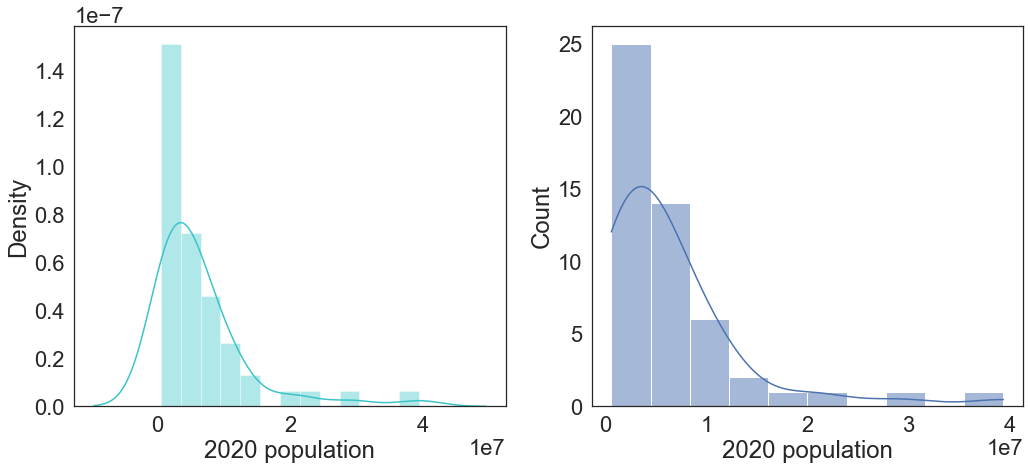

In [8]:
sns.set(style="white", font_scale=2)
plt.rcParams['figure.figsize'] = (17, 7)

plt.subplot(1, 2, 1)
sns.distplot(population['2020 population'], color='#3BC4C7');
plt.subplot(1, 2, 2)
sns.histplot(population['2020 population'], bins=10, kde=True)

<AxesSubplot:xlabel='2020 population', ylabel='state'>

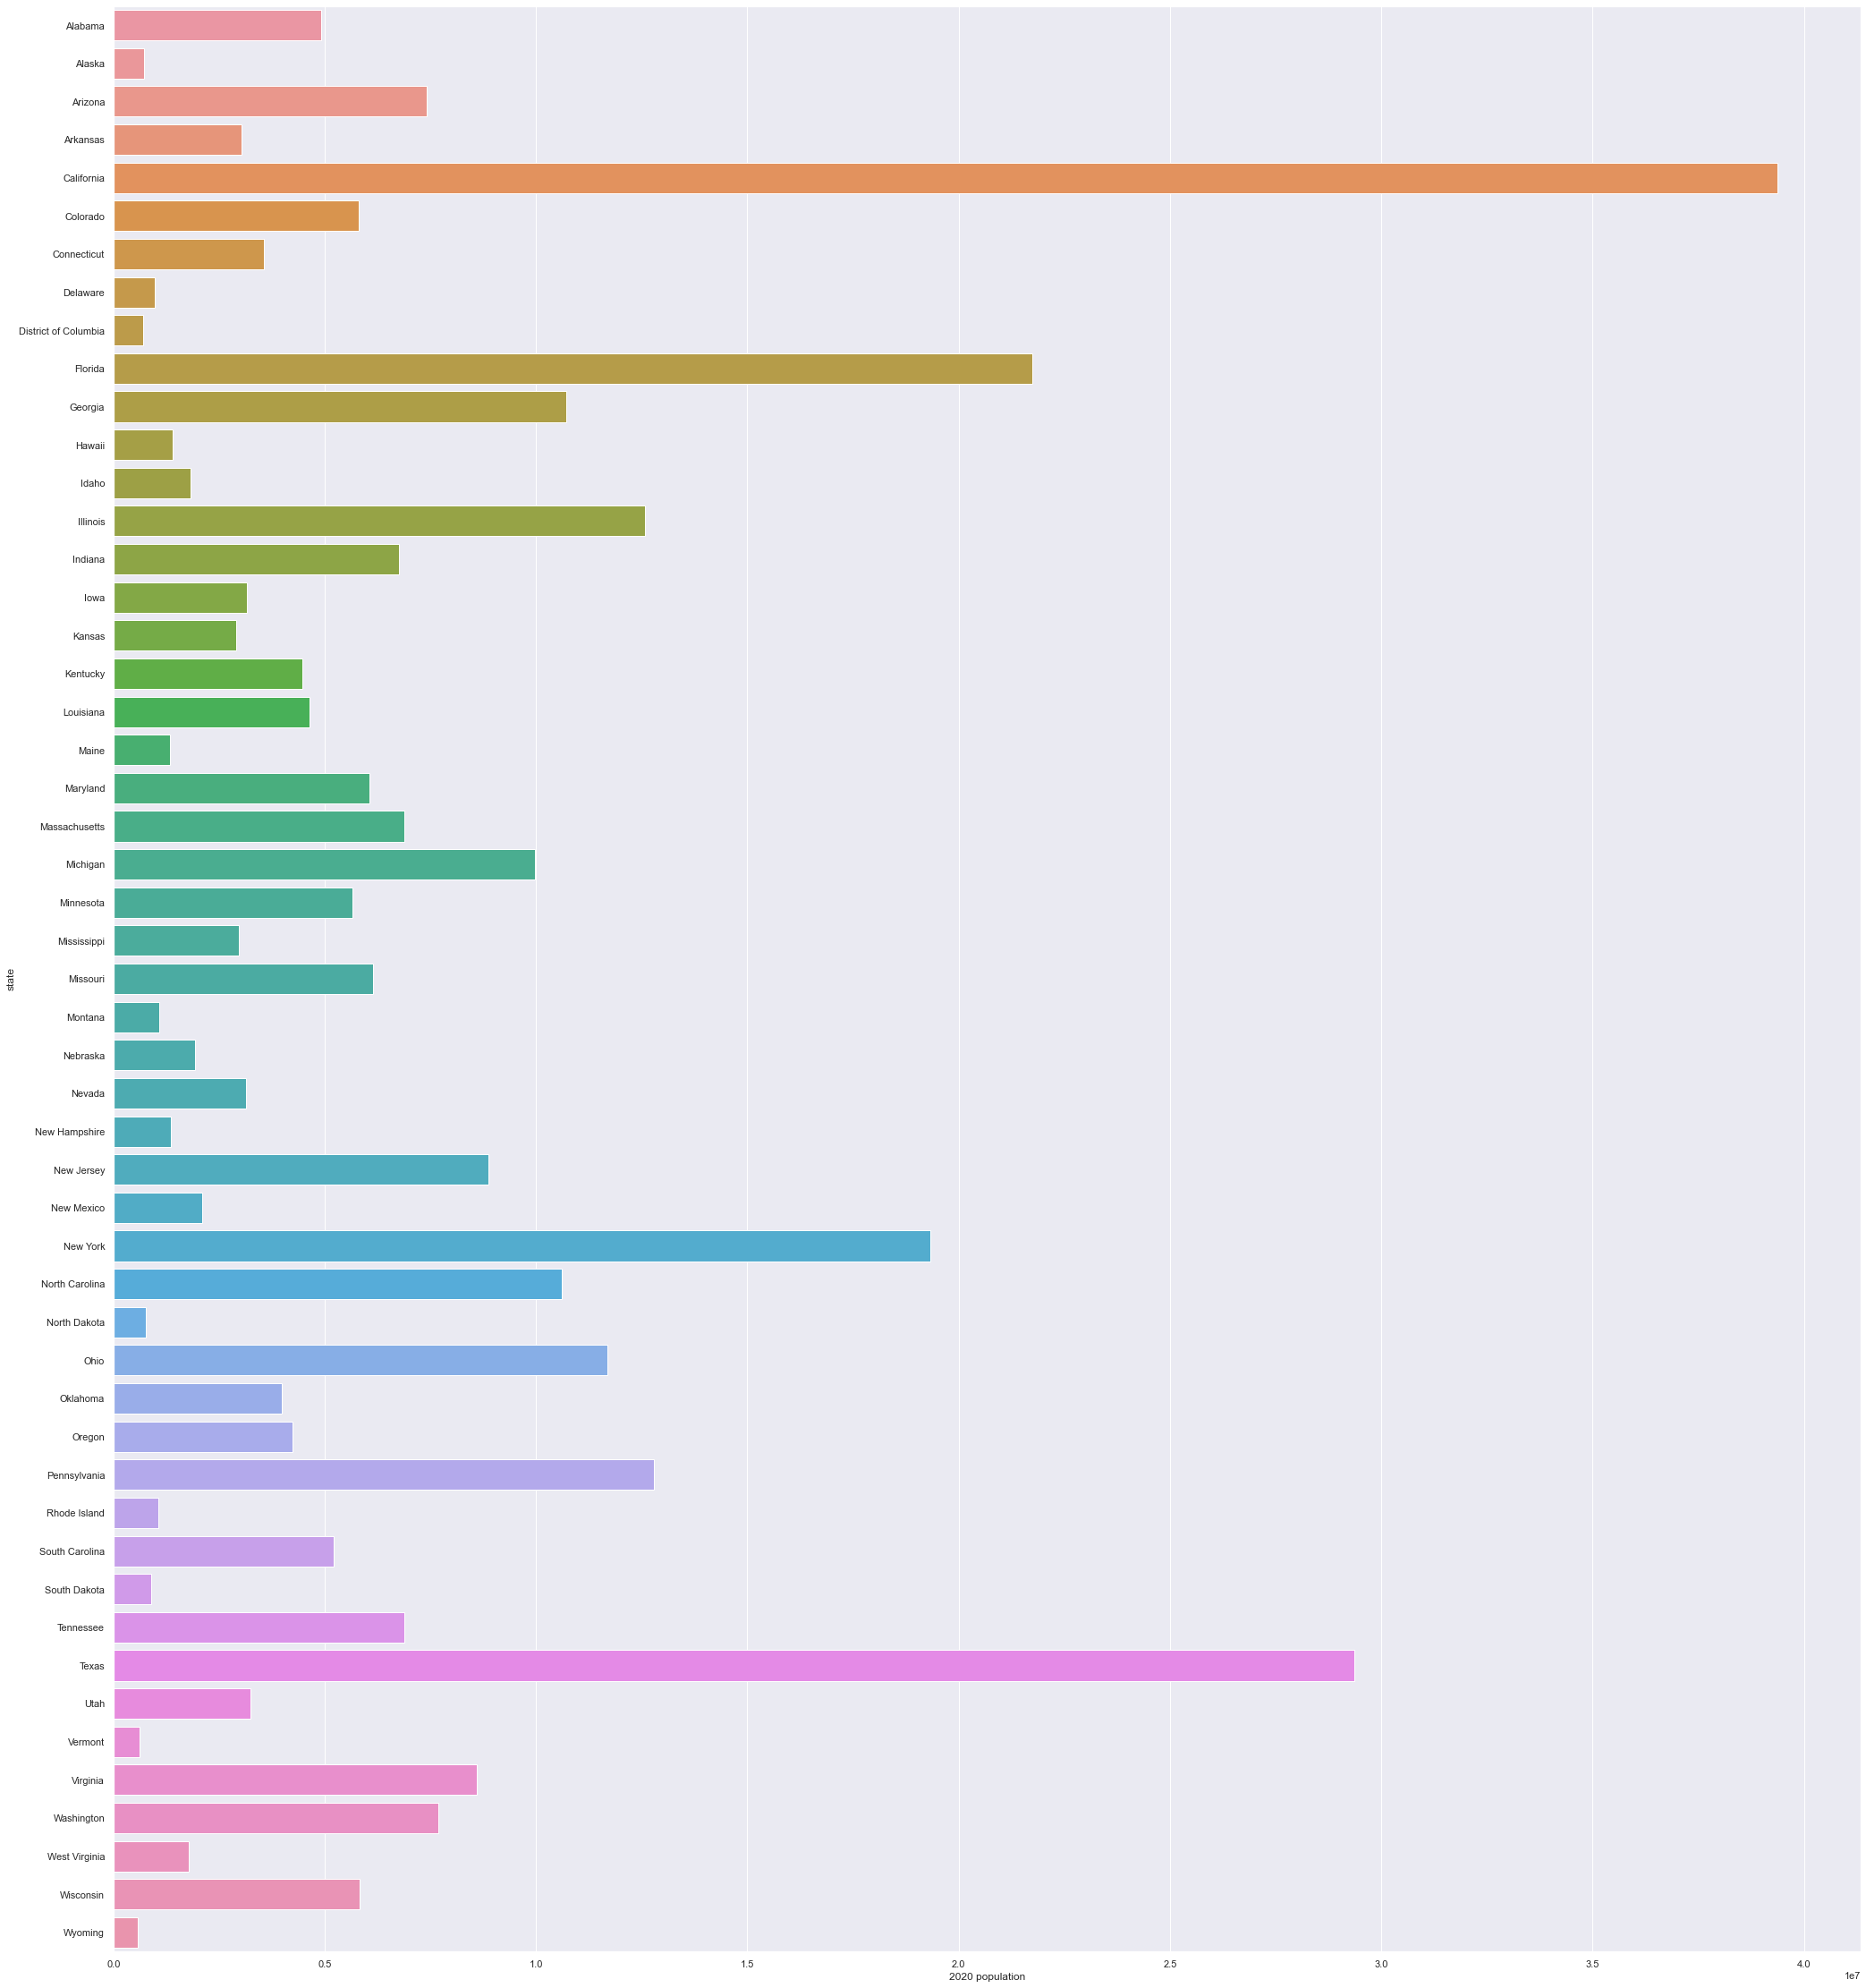

In [9]:
sns.set(rc={'figure.figsize':(35,40)})
sns.barplot(x=population['2020 population'], y='state', data=population)

In [10]:
most_recent = merged_data[merged_data['date'] == '2021-02-23']
most_recent = pd.merge(most_recent, population, on = ['state'], how='left')
most_recent['proportion'] = most_recent['people vaccinated']/most_recent['2020 population']

<AxesSubplot:xlabel='proportion', ylabel='state'>

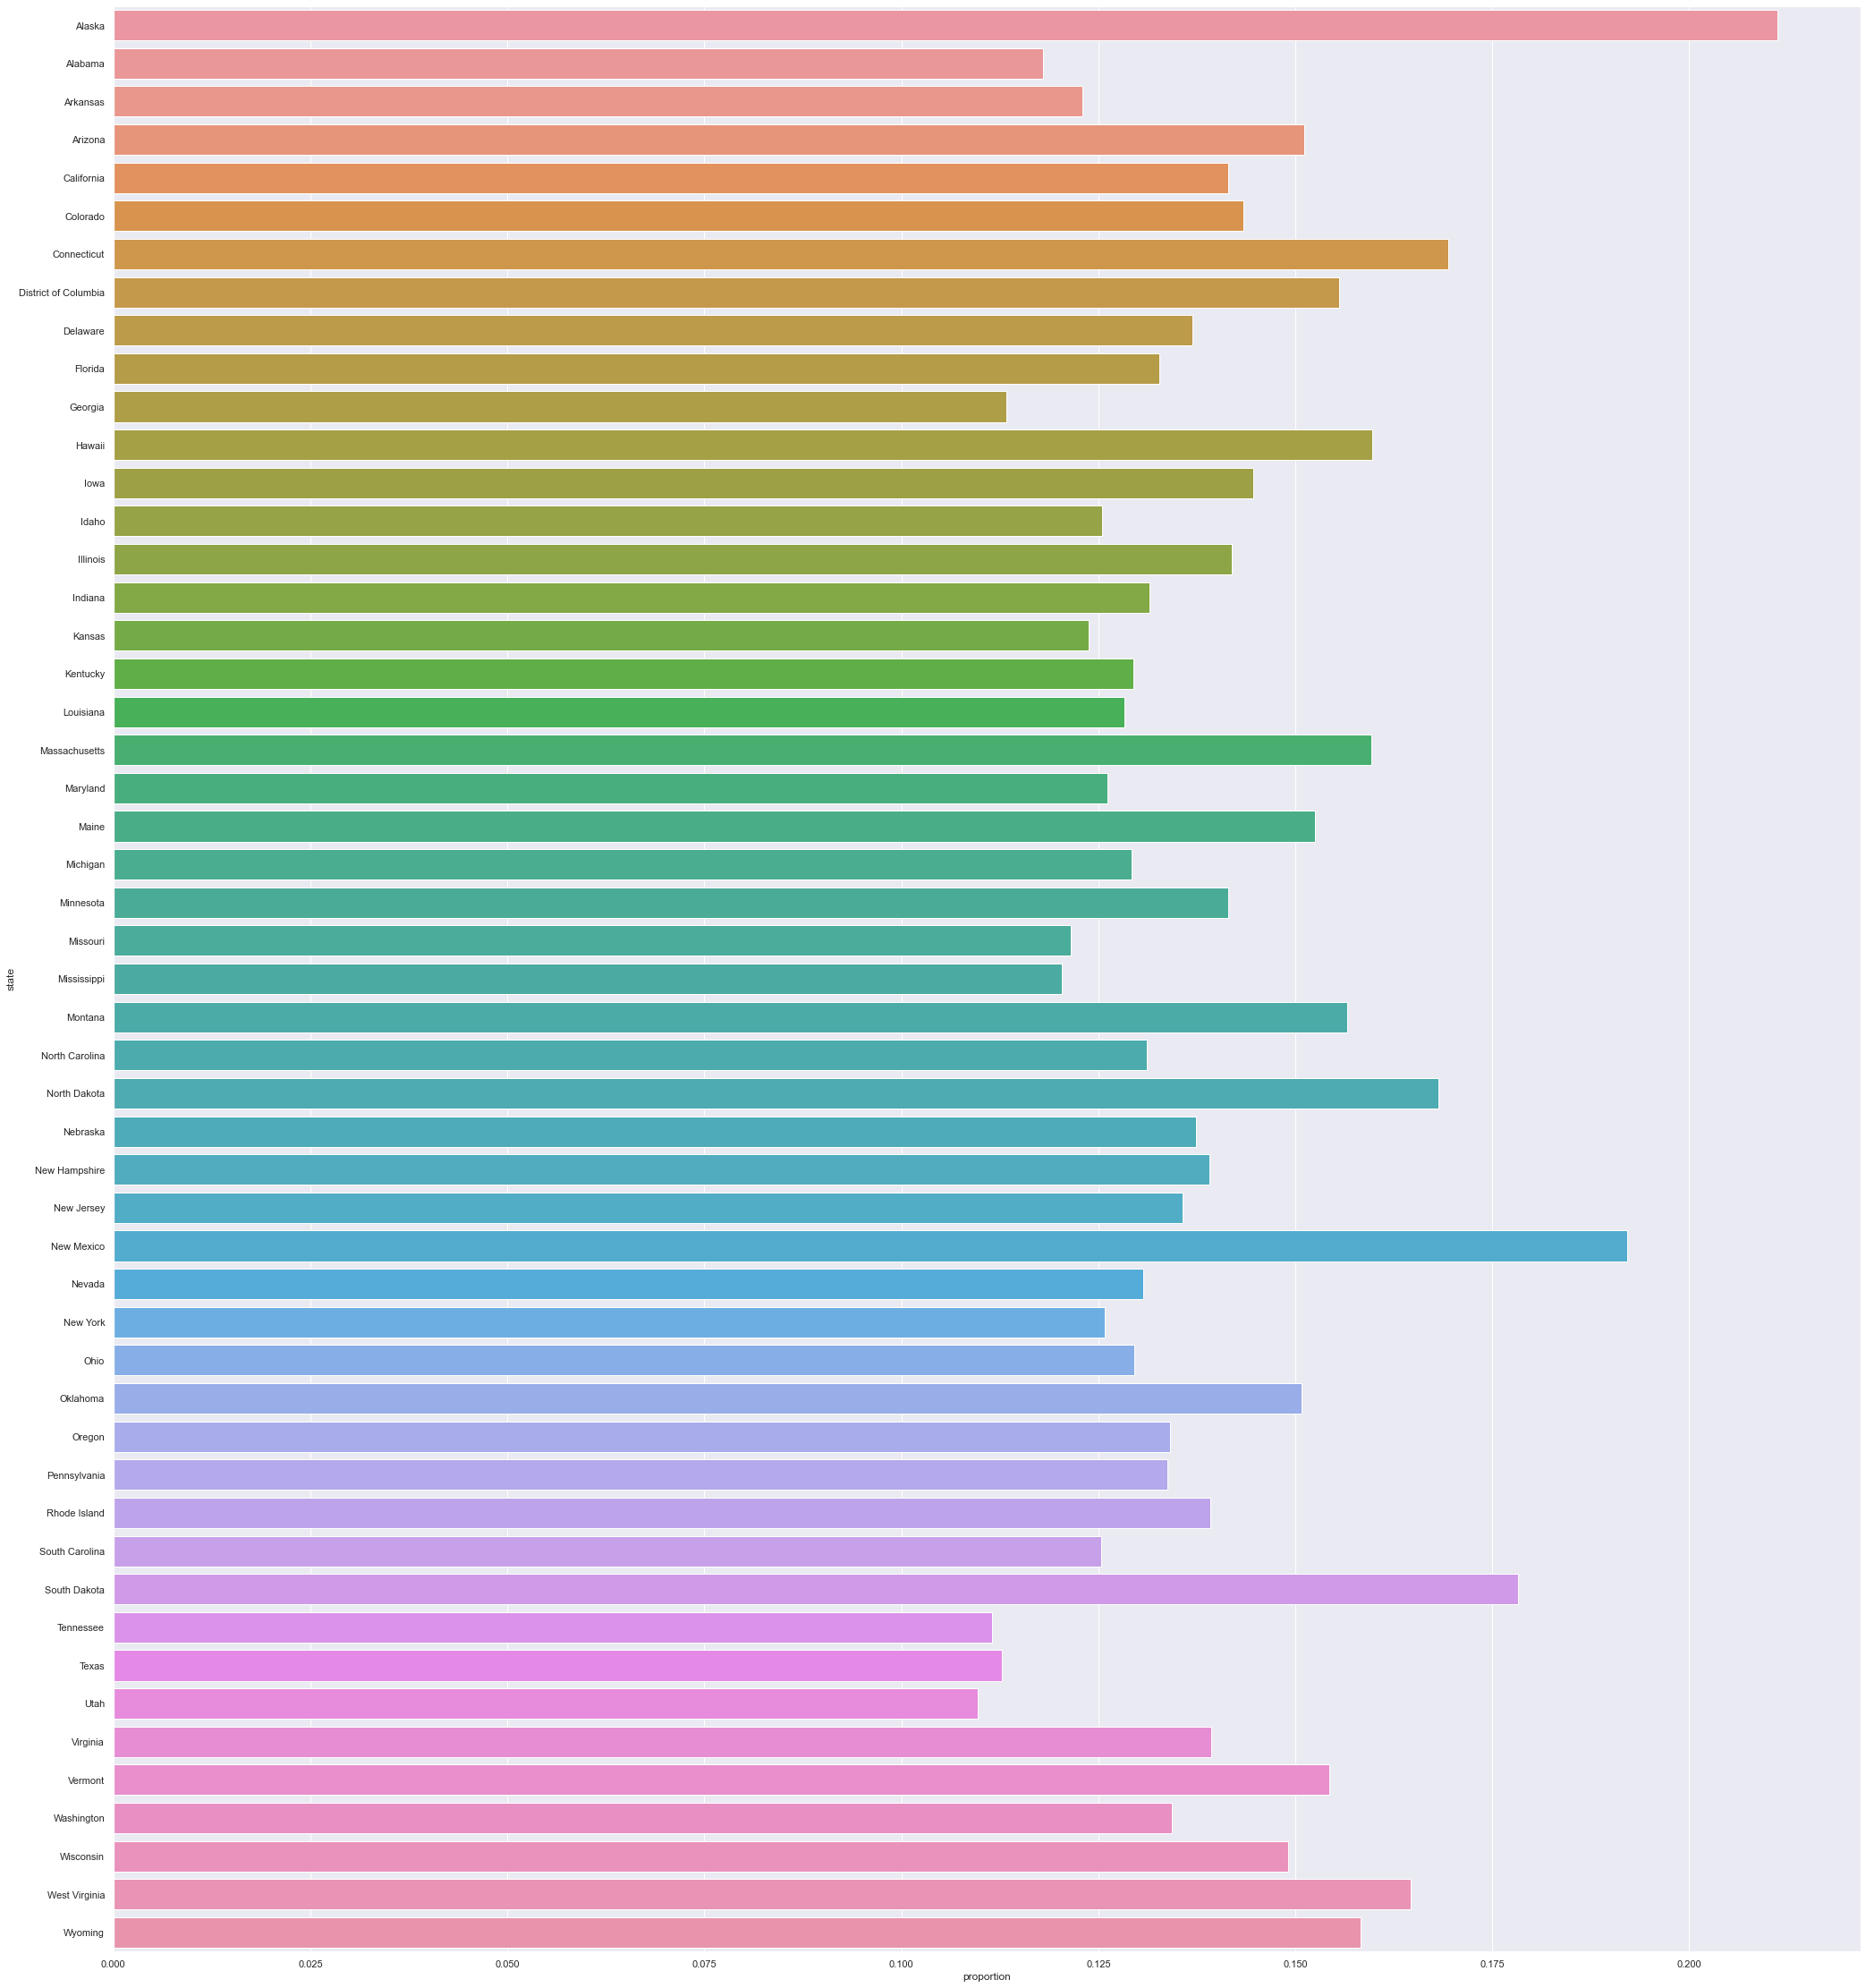

In [11]:
sns.set(rc={'figure.figsize':(35,40)})
sns.barplot(x=most_recent['proportion'], y='state', data=most_recent)

In [12]:
most_recent['people vaccinated'].isnull().sum()

0

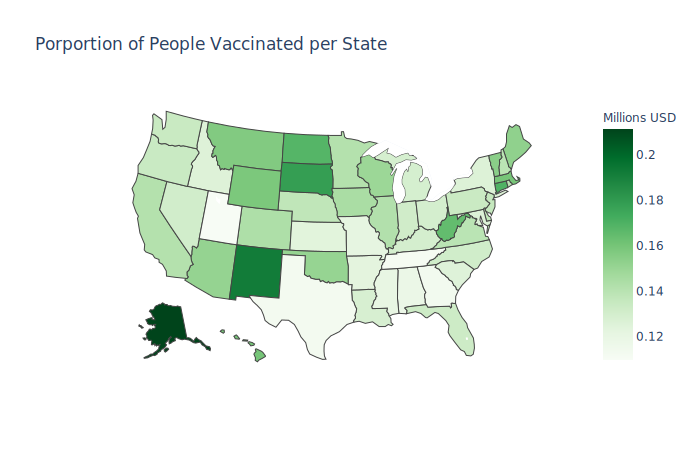

In [13]:
for i,j in state_code.iterrows():
    most_recent.loc[most_recent.state == state_code.loc[i]['State'], ['state']] = state_code.loc[i]['Abbreviation']


pio.renderers

fig = go.Figure(data=go.Choropleth(
    locations=most_recent['state'], # Spatial coordinates
    z = most_recent['proportion'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = 'Porportion of People Vaccinated per State',
    geo_scope='usa', # limite map scope to USA
)

fig.show(renderer="svg")